# Pré-processamento e Construção de Modelos

Neste notebook, abordaremos conceitos essenciais em data science construindo um modelo para a previsão da energia livre de solvatação(ou Energia Livre de Gibbs)- uma medida da facilidade de uma molécula se dissolver em água. Usaremos Morgan Fingerprints como representações moleculares.

- Data Cleaning;
- Preparação dos dados para predição;
- Treinamento e inferência de um modelo de machine learning;

Tentaremos prever o valor experimental dessa medida com base em outros dados moleculares.

## Importando bibliotecas

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 28.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import requests

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


warnings.filterwarnings('ignore')

## Carregando o dataset

Usaremos o [FreeSolv](https://github.com/MobleyLab/FreeSolv) dataset neste exercício. Ele é um banco de dados curado de energias de solvatação livres (ou Energia Livre de Gibbs) experimentais e calculadas para pequenas moléculas em água. Os valores experimentais são extraídos da literatura anterior e continuarão a ser curados, com referências e dados experimentais atualizados sendo adicionados à medida que se tornarem disponíveis.

In [3]:
# função de carregamento do dataset
def load_freesolv_dataset():
    """Carrega o dataset FreeSolv"""
    url = "https://raw.githubusercontent.com/MobleyLab/FreeSolv/master/database.txt"
    response = requests.get(url)
    response.raise_for_status()

    # quebra o arquivo separado em ponto e vírgula em linhas
    lines = response.text.strip().split('\n')

    # filtra linhas de dados
    data_lines = [line for line in lines if not line.startswith('#') and line.strip()]

    # inicializa listas úteis
    smiles_list = []
    names_list = []
    expt_values = []
    calc_values = []

    for line in data_lines:
        parts = [p.strip() for p in line.split(';')]
        if len(parts) >= 6:  # verifica se temos campos suficientes
            smiles = parts[1]  # SMILES string
            name = parts[2]    # nome da molecula
            try:
                exp_value = float(parts[3])   # energia de solvatação livre experimental
                calc_value = float(parts[5])  # energia de solvatação livre calculada
                # Valida o SMILES antes de adicionar
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    smiles_list.append(smiles)
                    names_list.append(name)
                    expt_values.append(exp_value)
                    calc_values.append(calc_value)
            except ValueError:
                continue

    df = pd.DataFrame({
        'SMILES': smiles_list,
        'name': names_list,
        'expt': expt_values,
        'calc': calc_values
    })

    print(f"FreeSolv dataset carregado com {len(df)} compostos")# Load dataset

    print("Colunas no dataset:", df.columns.tolist())

    return df


df = load_freesolv_dataset()

FreeSolv dataset carregado com 642 compostos
Colunas no dataset: ['SMILES', 'name', 'expt', 'calc']


In [4]:
# visualizando as primeiras linhas do dataset
df.head()

,SMILES,name,expt,calc
0,CCCCCC(=O)OC,methyl hexanoate,-2.49,-3.30
1,CCCCO,butan-1-ol,-4.72,-3.23
2,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,-1.08
3,C1CCC(CC1)N,cyclohexanamine,-4.59,-3.95
4,c1ccc(cc1)OC=O,phenyl formate,-3.82,-5.44


## EDA

A análise exploratória de dados (EDA) é a etapa inicial do estudo de um conjunto de dados, cujo objetivo é compreender suas principais características por meio de estatísticas descritivas e visualizações, como gráficos e tabelas.

Ela permite identificar padrões, tendências, outliers, inconsistências e possíveis relações entre variáveis antes da aplicação de modelos ou técnicas mais avançadas. A EDA é importante porque ajuda a garantir a qualidade dos dados, orienta a escolha de métodos analíticos adequados e reduz o risco de interpretações incorretas ou conclusões enviesadas.

Vamos visualizar a distribuição dos valores de energia livre de hidratação experimental (`expt`) usando um histograma.

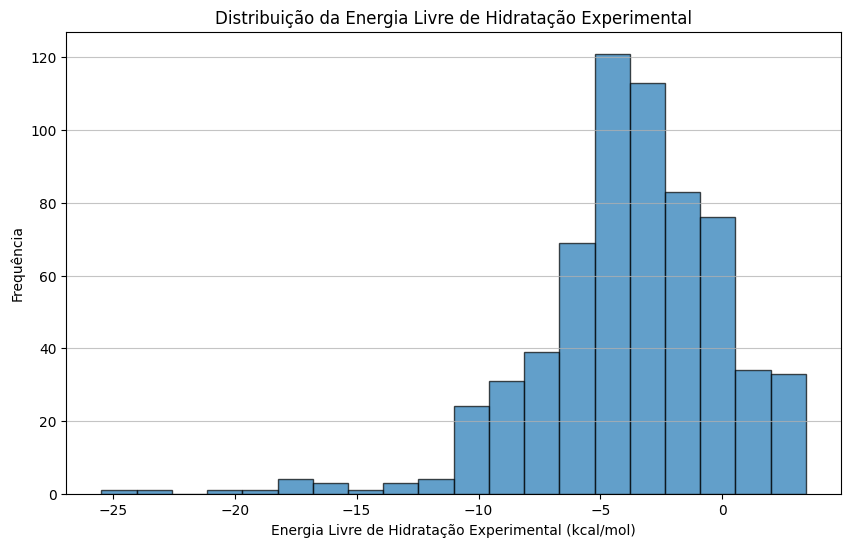

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df['expt'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribuição da Energia Livre de Hidratação Experimental')
plt.xlabel('Energia Livre de Hidratação Experimental (kcal/mol)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

Com base no diagrama acima, é possível observar que a distribuição é segue uma curva normal, centrada em -4 kcal/mol, o que indica que a média dos valores de Energia Livre estão próximas desse valor.

Podemos analisar também o alcance (mínimo e máximo) e outras estatísticas descritivas da variável alvo, `expt`

In [6]:
print('Estatísticas Descritivas para a Energia Livre de Hidratação Experimental:')
display(df['expt'].describe())

Estatísticas Descritivas para a Energia Livre de Hidratação Experimental:


,expt
count,642.000000
mean,-3.803006
std,3.847820
min,-25.470000
25%,-5.727500
50%,-3.530000
75%,-1.215000
max,3.430000


## Feature Engineering

O processo de feature engineering(ou engenharia de recursos) é fundamental em aprendizado de máquina, pois consiste em transformar dados brutos em características relevantes, ou gerar novos dados, que representem melhor o problema a ser resolvido. Assim, impacta diretamente a performance final, podendo melhorar a acurácia, a capacidade de generalização e a eficiência computacional pois destaca padrões importantes e diminui a dimensionalidade dos dados, facilitando o aprendizado do modelo. Porém, uma extração inadequada pode levar a modelos imprecisos ou com overfitting.

Vamos calcular o descritor molecular LogP (coeficiente de partição) para cada molécula no dataset usando a biblioteca RDKit. O LogP é uma medida da lipofilicidade de uma molécula, que é importante em diversas áreas da química e farmacologia.

In [7]:
# Função para calcular o LogP
def calculate_logp(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return Descriptors.MolLogP(mol)
        else:
            return None
    except:
        return None

# Aplicar a função para criar uma nova coluna 'LogP'
df['LogP'] = df['SMILES'].apply(calculate_logp)

# Remover linhas onde o cálculo do LogP falhou (se houver)
df.dropna(subset=['LogP'], inplace=True)

print(f"LogP calculado para {len(df)} compostos. Primeiras 5 linhas com LogP:")
display(df.head())

LogP calculado para 642 compostos. Primeiras 5 linhas com LogP:


,SMILES,name,expt,calc,LogP
0,CCCCCC(=O)OC,methyl hexanoate,-2.49,-3.30,1.7397
1,CCCCO,butan-1-ol,-4.72,-3.23,0.7788
2,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,-1.08,7.2740
3,C1CCC(CC1)N,cyclohexanamine,-4.59,-3.95,1.2778
4,c1ccc(cc1)OC=O,phenyl formate,-3.82,-5.44,1.2218


Agora, vamos visualizar a distribuição dos valores de LogP usando um histograma para entender a faixa e a frequência desses valores no dataset.

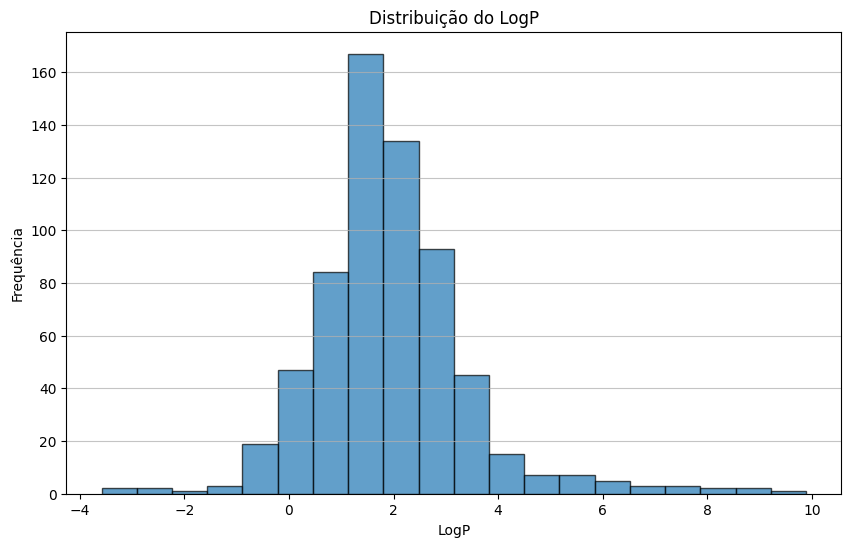

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df['LogP'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribuição do LogP')
plt.xlabel('LogP')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

Um diagrama de caixa (também conhecido como diagrama de caixa e bigodes) usa caixas e linhas para representar a distribuição de um ou mais grupos de dados numéricos. Os limites das caixas indicam a amplitude dos 50% centrais dos dados, com uma linha central marcando o valor mediano. Linhas se estendem a partir de cada caixa para capturar a amplitude dos dados restantes, com pontos colocados além das bordas das linhas para indicar valores discrepantes (outliers).

Vamos usá-lo para verificar a presença de valores discrepantes para a variável `LogP`.

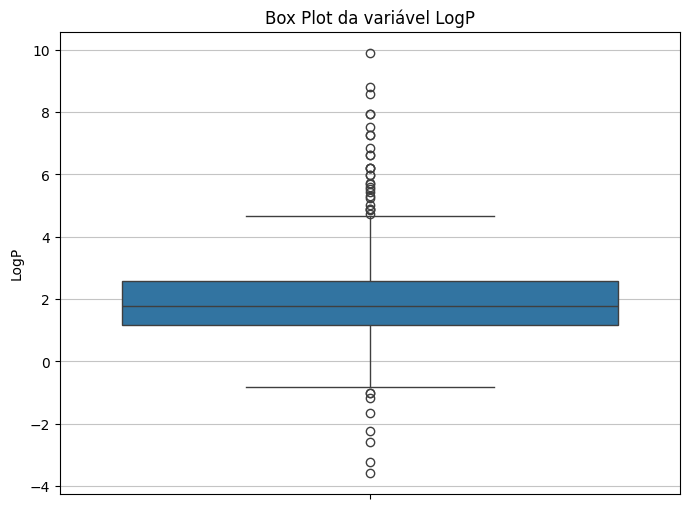

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['LogP'])
plt.title('Box Plot da variável LogP')
plt.ylabel('LogP')
plt.grid(axis='y', alpha=0.75)
plt.show()

Observando o boxplot acima, é possível notar que há outliers (indicados pelas bolinhas) na distribuição de `LogP`. Precisamos tratar esses valores, já que eles podem afetar negativamente a performance do modelo.

## Data Cleaning

Há várias formas de tratar outliers. No nosso caso, vamos escolher remover esses valores por fins pedagógicos, já que este método é considerado mais simples.

Para isso, vamos utilizar o método da diferença interquartil(ou Interquartile Range- IQR) para selecionar e remover os outliers presentes.

Primeiro, os dados são ordenados e divididos em quartis. O primeiro quartil (Q1) corresponde ao valor abaixo do qual estão 25% dos dados, enquanto o terceiro quartil (Q3) indica o valor abaixo do qual estão 75% dos dados. A diferença interquartil é calculada como IQR = Q3 − Q1, representando a faixa onde se concentram os 50% centrais dos dados.

Para detecção de outliers, definem-se limites inferiores e superiores:

- Limite inferior: Q1 − 1,5 × IQR

- Limite superior: Q3 + 1,5 × IQR

Valores que ficam fora desse intervalo são considerados potenciais outliers. A principal vantagem desse método é que ele é robusto a valores extremos, pois se baseia nos quartis e não na média, tornando-o adequado para dados assimétricos ou com ruído.

Dataset original: 642 linhas
Dataset após remover outliers: 606 linhas

Novas Estatísticas Descritivas para LogP


,LogP
count,606.000000
mean,1.780629
std,1.057643
min,-0.820800
25%,1.144325
50%,1.743900
75%,2.505450
max,4.660400


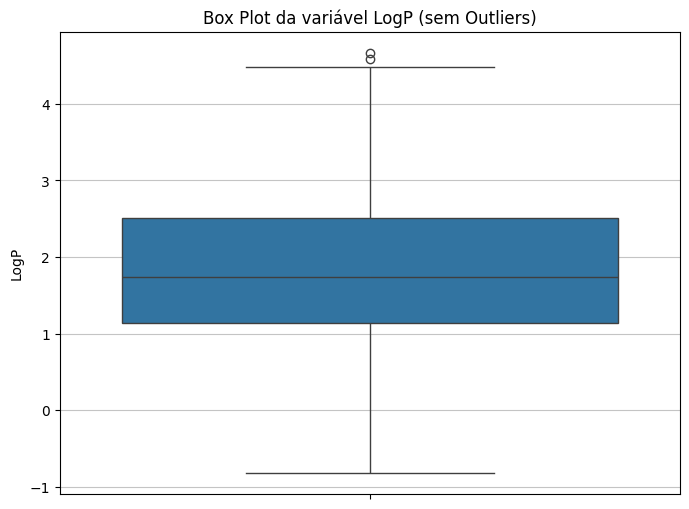

In [10]:
Q1 = df['LogP'].quantile(0.25)
Q3 = df['LogP'].quantile(0.75)
IQR = Q3 - Q1

# Definição do limite inferior para outliers
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Aplicar o filtro para remover outliers
df_filtered = df[(df['LogP'] >= lower_bound_iqr) & (df['LogP'] < upper_bound_iqr)].copy()

print(f"Dataset original: {len(df)} linhas")
print(f"Dataset após remover outliers: {len(df_filtered)} linhas")

df = df_filtered # Atualiza o DataFrame principal

print('\nNovas Estatísticas Descritivas para LogP')
display(df['LogP'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['LogP'])
plt.title('Box Plot da variável LogP (sem Outliers)')
plt.ylabel('LogP')
plt.grid(axis='y', alpha=0.75)
plt.show()

Após a limpeza dos dados, podemos visualizar a correlação que cada variável possui com relação ao restante do dataset.Quanto mais próximo de 1, maior a influência de uma feature sobre uma outra.

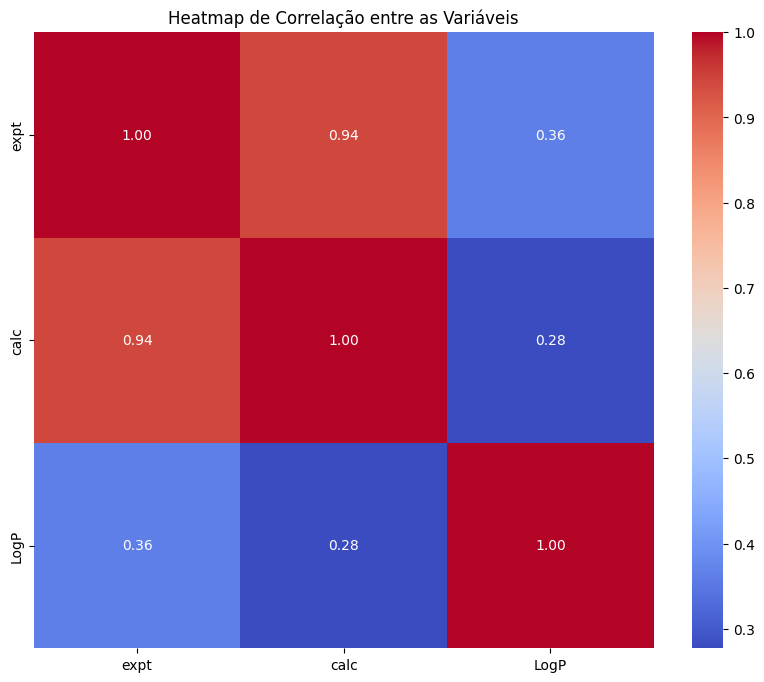

In [11]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlação entre as Variáveis')
plt.show()

Com base no heatmap acima, podemos constatar que a variável `calc` exerce a maior influência sobre a variável que estamos tentanto prever.

### Prática

Com base nas células anteriores e no notebook desenvolvido no módulo 1, adicione as colunas de peso molecular(`MolWt`) e plote a sua distribuição. Você consegue identificar algum outlier? Essa nova feature tem correlação com alguma outra variável do dataset?

Dataset original: 606 linhas
Dataset após remover outliers: 579 linhas

Novas Estatísticas Descritivas para MolWt


,MolWt
count,579.000000
mean,121.655268
std,44.411938
min,16.043000
25%,90.156500
50%,117.148000
75%,146.337500
max,241.364000


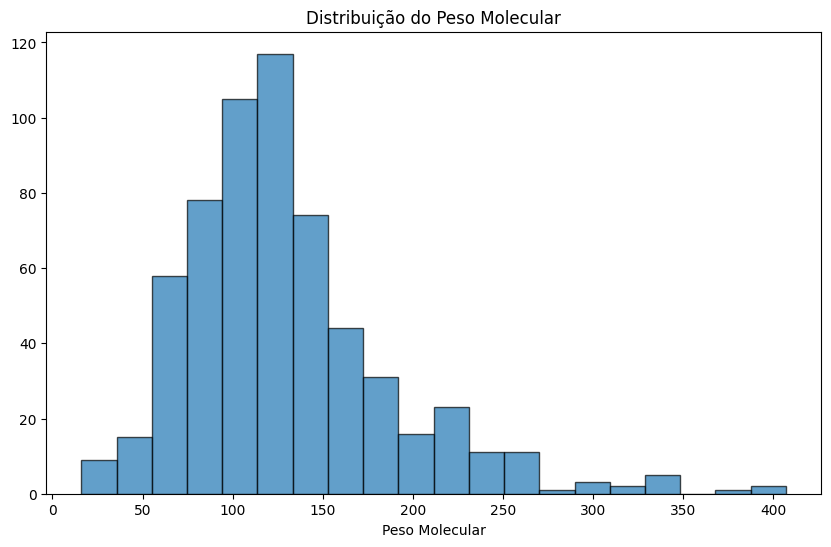

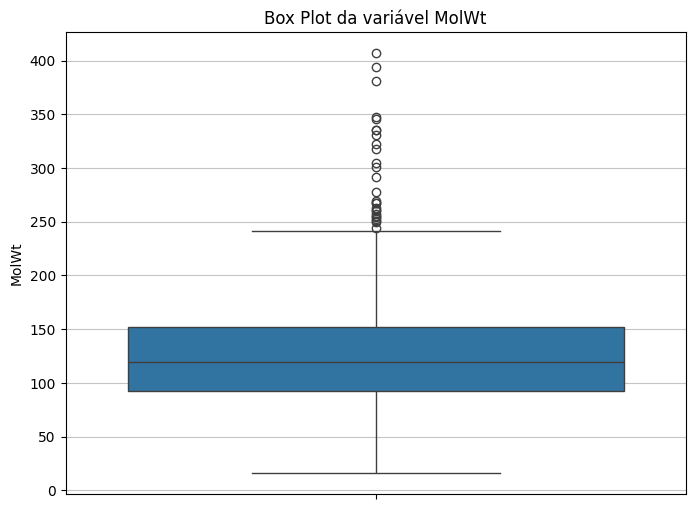

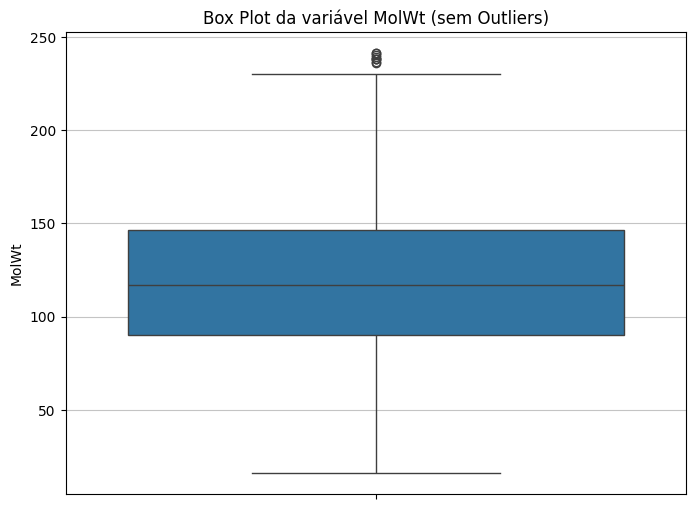

In [12]:


#########################################
#### ESPAÇO PARA O CÓDIGO DA PRÁTICA ####
#########################################

def calcualte_mol_weight(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return Descriptors.MolWt(mol)
        else:
            return None
    except:
        return None

df['MolWt'] = df['SMILES'].apply(calcualte_mol_weight)
df.dropna(subset=['MolWt'], inplace=True)

plt.figure(figsize=(10, 6))
plt.hist(df['MolWt'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Peso Molecular')
plt.xlabel('Peso Molecular')


#plotar boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['MolWt'])
plt.title('Box Plot da variável MolWt')
plt.ylabel('MolWt')
plt.grid(axis='y', alpha=0.75)

#remover outliers
Q1 = df['MolWt'].quantile(0.25)
Q3 = df['MolWt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

df_filtered = df[(df['MolWt'] >= lower_bound_iqr) & (df['MolWt'] < upper_bound_iqr)].copy()

print(f"Dataset original: {len(df)} linhas")
print(f"Dataset após remover outliers: {len(df_filtered)} linhas")

df = df_filtered # Atualiza o DataFrame principal

print('\nNovas Estatísticas Descritivas para MolWt')
display(df['MolWt'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['MolWt'])
plt.title('Box Plot da variável MolWt (sem Outliers)')
plt.ylabel('MolWt')
plt.grid(axis='y', alpha=0.75)

## Treinando um Modelo

Antes de construirmos o modelo, precisamos separar o dataset entre os dados que serão utilizados no treinamento do modelo(treino) e os que serão utilizados para analisar a sua performance(teste)

In [13]:
# Definindo features (X) e target (y)
# usaremos apenas features numéricas, por exigência do modelo escolhido
y = df['expt']
X = df.drop(['expt', 'SMILES', 'name'], axis=1)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treinamento: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treinamento: 463 amostras
Tamanho do conjunto de teste: 116 amostras


Com os dados já tratados, podemos partir para a definição e treinamento do modelo de predição. Usaremos um modelo de regressão linear para prever os valores da variável `expt`.


Mean Squared Error (MSE): 0.88
R-squared (R2): 0.92


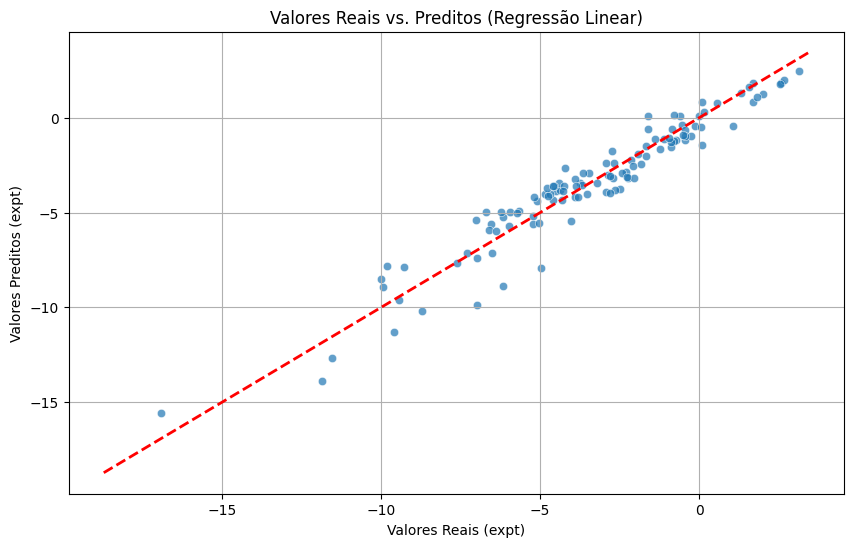

In [14]:
# Inicializar e treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Visualizar os resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Linha de 45 graus
plt.xlabel('Valores Reais (expt)')
plt.ylabel('Valores Preditos (expt)')
plt.title('Valores Reais vs. Preditos (Regressão Linear)')
plt.grid(True)
plt.show()